# BERT: Data

# Imports

Downloading key dependencies.

In [4]:
# !brew install gcc@11 pkg-config poppler ocrmypdf
# !pip install monopoly-core openai dotenv pandas matplotlib numpy

In [ ]:
import pandas as pd
import re
import os
import monopoly
from monopoly.banks import BankDetector, banks
from monopoly.pdf import PdfDocument, PdfParser
from monopoly.pipeline import Pipeline
from dotenv import load_dotenv
import openai
import time
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import json
import random

# Data

In [125]:
pdf_dir = "/Users/arnoldlek/Desktop/DSA4265/dsa4265-project/models/bert/data/Personal Data"

pdf_files = []
for filename in os.listdir(pdf_dir):
    if filename.lower().endswith(".pdf"):
        pdf_files.append(os.path.join(pdf_dir, filename))

In [126]:
def statement_parser(pdf_path):

    document = PdfDocument(file_path=pdf_path)
    parser = PdfParser(BankDetector(document).detect_bank(banks), document)
    pipeline = Pipeline(parser)

    statement = pipeline.extract()
    transactions = pipeline.transform(statement)

    file_path = pipeline.load(
        transactions=transactions,
        statement=statement,
        output_directory="./data/extracted-data",
    )

    with open(file_path, encoding="utf8") as file:
        print(f"Showing {file_path}:\n")
        print(file.read()[0:248])
    
    return

In [127]:
for pdf in pdf_files:
    statement_parser(pdf)

Showing data/extracted-data/ocbc-debit-2023-10-b39dfa.csv:

date,description,amount
2023-10-01,FUND TRANSFER via PayNow-QR Code to QFPAY SINGAPORE OTHR - QF2023100102004573,-6.7
2023-10-01,DEBIT PURCHASE 29/09/23 xx-0411 LE TACH VENDING S,-0.9
2023-10-01,DEBIT PURCHASE 29/09/23 xx-4909 TS/UDON DON BAR NUS S
Showing data/extracted-data/ocbc-debit-2024-04-1ae1d5.csv:

date,description,amount
2024-03-31,DEBIT PURCHASE 30/03/24 xx-0411 HA JUN (CLEMENTI MALL) S,-6.8
2024-03-31,FAST PAYMENT via PayNow-Mobile to TEO WEE KENG KEN OTHR - OTHR,-4.9
2024-03-31,COLLECTION/TRANSFER UBIL Arnold 90da19d7cc5b4e96abf GRABPAY T
Showing data/extracted-data/ocbc-debit-2024-02-cdf458.csv:

date,description,amount
2024-02-01,FUND TRANSFER via PayNow-QR Code to QFPAY SINGAPORE OTHR - QF2024020102005516,-5.5
2024-02-01,PAYMENT/TRANSFER UOVB from WONG MEI YIN STDY Living allowance,500.0
2024-02-02,NETS QR 90894701 NETS QR PURCHASE PASTA 
Showing data/extracted-data/ocbc-debit-2023-12-114d81.csv:

date,descript

# Labelling

In [128]:
load_dotenv()
api_key = os.getenv("API-KEY")
client = openai.OpenAI(api_key=api_key)

In [129]:
# Load all data into a combined dataset.
csv_dir = "/Users/arnoldlek/Desktop/DSA4265/dsa4265-project/models/bert/data/extracted-data"
csv_files = [f for f in os.listdir(csv_dir) if not f.startswith("combined_output") and f.endswith(".csv")]

dfs = []
for file in csv_files:
    full_path = os.path.join(csv_dir, file)
    df = pd.read_csv(full_path)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893 entries, 0 to 1892
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1893 non-null   object 
 1   description  1893 non-null   object 
 2   amount       1893 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.5+ KB


In [130]:
def create_prompt(transaction):
    return f"""
You are a financial assistant. Categorize the following transaction:
Description: {transaction['description']}
Amount: {transaction['amount']}
Date: {transaction['date']}

Label this with:
1. Type (Deposit/Withdrawal)
2. Category 
3. Short Explanation

The category labels you can use are Food, Groceries, Transport, Shopping, Bills, Entertainment, Health, Income, Transfers and Miscellaneous.
"""

In [131]:
def parse_label_output(label_text):
    try:
        type_match = re.search(r"1\.\s*Type:\s*(.*)", label_text)
        cat_match = re.search(r"2\.\s*Category:\s*(.*)", label_text)
        expl_match = re.search(r"3\.\s*Short Explanation:\s*(.*)", label_text)

        return pd.Series({
            "type": type_match.group(1).strip() if type_match else None,
            "category": cat_match.group(1).strip() if cat_match else None,
            "explanation": expl_match.group(1).strip() if expl_match else None
        })
    except Exception as e:
        print(f"Error parsing label: {e}")
        return pd.Series({"type": None, "category": None, "explanation": None})


In [132]:
def label_transaction(transaction):
    prompt = create_prompt(transaction)
    try:    
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an assistant that labels financial transactions."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2,
        )
        label = response.choices[0].message.content
        print(label)
        return label
    
    except Exception as e:
        print(f"Error processing row: {transaction['description']}: {e}")
        return None

        

In [133]:
combined_df["label"] = combined_df.apply(label_transaction, axis=1)


2025-04-12 11:48:23,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
1. Type: Withdrawal
2. Category: Transfers
3. Short Explanation: This transaction is a transfer of funds to a person named Faith via Google Pay (GPay) using the PayNow-Mobile service.
2025-04-12 11:48:25,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
1. Type: Withdrawal
2. Category: Transfers
3. Short Explanation: This transaction is a fund transfer made via PayNow-QR Code to QFPAY in Singapore.
2025-04-12 11:48:27,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
1. Type: Deposit
2. Category: Income
3. Short Explanation: This is a deposit transaction, likely a government benefit or payment.
2025-04-12 11:48:29,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
1. Type: Withdrawal
2. Category: Transfers
3. Short Ex

In [134]:
parsed_cols = combined_df["label"].apply(parse_label_output)
merged_df = pd.concat([combined_df, parsed_cols], axis=1)
merged_df = merged_df.drop(columns=["label"])

In [135]:
merged_df

,date,description,amount,type,category,explanation
0,2023-12-01,FAST PAYMENT via PayNow-Mobile to Faith OTHR -...,-5.06,Withdrawal,Transfers,This transaction is a transfer of funds to a p...
1,2023-12-01,FUND TRANSFER via PayNow-QR Code to QFPAY SING...,-6.70,Withdrawal,Transfers,This transaction is a fund transfer made via P...
2,2023-12-01,GIRO OTHR GOV GOV,800.00,Deposit,Income,"This is a deposit transaction, likely a govern..."
3,2023-12-01,CASH WITHDRAWAL ATM VIA QR CODE OCBC-KENT RIDG...,-500.00,Withdrawal,Transfers,This transaction represents a cash withdrawal ...
4,2023-12-02,DEBIT PURCHASE 30/11/23 xx-0411 STARBUCKS@HOME...,-4.90,Withdrawal,Food,Payment for a purchase at Starbucks.
...,...,...,...,...,...,...
1888,2024-05-31,DEBIT PURCHASE 29/05/24 xx-0411 DIN TAI FUNG -...,-46.04,Withdrawal,Food,Payment for a meal at Din Tai Fung restaurant ...
1889,2024-05-31,DEBIT PURCHASE 29/05/24 xx-0411 COLD STORAGE-P...,-1.80,Withdrawal,Groceries,"Purchase made at Cold Storage, a grocery store..."
1890,2024-05-31,DEBIT PURCHASE 28/05/24 xx-5494 SHOPEE SINGAPO...,-13.73,Withdrawal,Shopping,"This transaction is a purchase made on Shopee,..."
1891,2024-05-31,DEBIT PURCHASE 29/05/24 xx-6482 EZ-LINK APP S,-20.00,Withdrawal,Transport,This is a payment for a transport service thro...


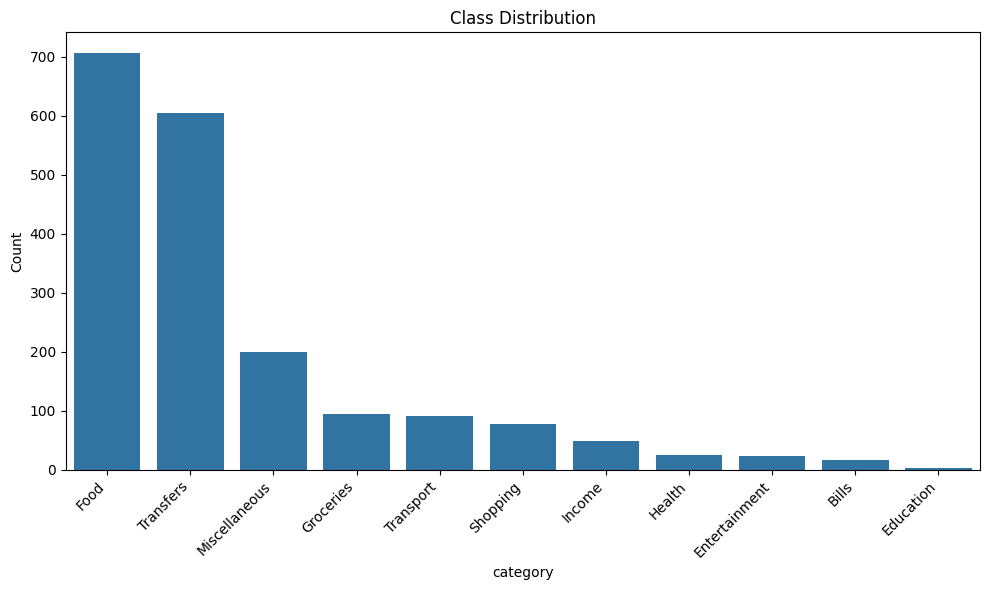

In [145]:
# Count classes
class_counts = merged_df['category'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)

# Automatically align tick labels with class names
plt.xticks(rotation=45, ha='right')  # Rotates for better visibility
plt.ylabel("Count")
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

In [139]:
merged_df.to_csv(f"{csv_dir}/combined_output.csv", index=False)

## Synthesizing Data

In [158]:
# Adjusted based on class distribution
underrepresented = {
    "Education": 300,
    "Bills": 300,
    "Entertainment": 300,
    "Health": 300,
    "Income": 300,
    "Shopping": 200,
    "Transport": 200,
    "Groceries": 200
}

In [ ]:
def create_structured_prompt(category):
    return f"""
You are generating synthetic bank transaction records for training a financial classifier.

Please follow the strict formatting rules and adhere to the definition of the category provided.

---

CATEGORY DEFINITIONS:

- **Food**: Any purchase at restaurants, cafes, fast food, or online food delivery.
- **Transport**: Expenses related to buses, trains, taxis, ride-hailing apps, or EZ-Link.
- **Groceries**: Purchases from supermarkets, convenience stores, or online grocery platforms.
- **Shopping**: Retail purchases, both online (e.g., Shopee, Lazada) and offline (e.g., Uniqlo, Zara).
- **Bills**: Regular payments like utilities, telco bills, streaming subscriptions.
- **Income**: Salary, interest credited, government transfers, freelance payments.
- **Transfers**: Sending or receiving money via PayNow, FAST, GIRO, or ATM withdrawals.
- **Health**: Payments at clinics, pharmacies, dental, insurance top-ups.
- **Education**: Tuition fees, school payments, textbook purchases.
- **Entertainment**: Movie tickets, games, bars, karaoke, concert tickets.

---

OUTPUT FORMAT:

Each record must follow this exact format and syntax:
- **date**: Format as YYYY-MM-DD
- **description**: Make it look like a real transaction (e.g., DEBIT PURCHASE, GIRO, FAST PAYMENT)
- **amount**: Use realistic decimal value (e.g., -4.90 or 500.00). Use negative values for withdrawals.
- **type**: Either 'Deposit' or 'Withdrawal'
- **category**: Always use "{category}" (ensure alignment with definition)
- **explanation**: Provide 1 short sentence explaining what the transaction is for

---

Please output **exactly 50 rows** in **valid JSON list** format like this:

[
  {{
    "date": "2023-12-01",
    "description": "DEBIT PURCHASE 30/11/23 xx-0411 STARBUCKS@HOME",
    "amount": -4.90,
    "type": "Withdrawal",
    "category": "{category}",
    "explanation": "Payment for a drink at Starbucks using a debit card."
  }},
  ...
]
"""

In [162]:
def generate_descriptions(category, count):
    descriptions = []
    while len(descriptions) < count:
        try:
            prompt = create_structured_prompt(category)
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": "You are an assistant that generates realistic bank transaction data."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.6
            )

            # Parse JSON output directly
            json_text = response.choices[0].message.content
            batch = json.loads(json_text)
            print(f"Entries generated: {batch}")
            print(f"Count: {len(batch)}")
            descriptions.extend(batch)

            print(f"Total entries: {len(descriptions)}")

        except Exception as e:
            print(f"Error for {category}: {e}")
            break

    return descriptions[:count]

# Main generation loop
synthetic_data = []
for cat, n in underrepresented.items():
    print(f"🔄 Generating {n} samples for '{cat}'...")
    records = generate_descriptions(cat, n)
    synthetic_data.extend(records)

# Save to CSV
df_synth = pd.DataFrame(synthetic_data)
df_synth.to_csv("./data/synthetic_augmented_data.csv", index=False)
print("Saved synthetic data to ./data/synthetic_augmented_data.csv")


🔄 Generating 300 samples for 'Education'...
2025-04-12 14:11:29,709 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Entries generated: [{'date': '2023-01-01', 'description': 'GIRO DEBIT 01/01/23 NATIONAL UNIVERSITY', 'amount': -500.0, 'type': 'Withdrawal', 'category': 'Education', 'explanation': 'Payment for tuition fees at National University.'}, {'date': '2023-01-15', 'description': 'DEBIT PURCHASE 15/01/23 POPULAR BOOKSTORE', 'amount': -30.0, 'type': 'Withdrawal', 'category': 'Education', 'explanation': 'Purchased textbooks at Popular Bookstore.'}, {'date': '2023-02-01', 'description': 'GIRO DEBIT 01/02/23 NATIONAL UNIVERSITY', 'amount': -500.0, 'type': 'Withdrawal', 'category': 'Education', 'explanation': 'Payment for tuition fees at National University.'}, {'date': '2023-02-10', 'description': 'DEBIT PURCHASE 10/02/23 AMAZON', 'amount': -15.0, 'type': 'Withdrawal', 'category': 'Education', 'explanation': 'Ordered an educational book

# Merge datasets

In [ ]:
synthetic_df = pd.read_csv('./data/synthetic_augmented_data.csv')

In [ ]:
final_df = pd.concat([merged_df, df_synth], axis=0)
final_df.to_csv("./data/final_dataset.csv", index=False)

## Cleaning up merged datasets

In [206]:
final_df = pd.read_csv("./data/final_dataset.csv")

In [207]:
# Inspect new merged dataset
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3993 non-null   object 
 1   description  3993 non-null   object 
 2   amount       3993 non-null   float64
 3   type         3993 non-null   object 
 4   category     3993 non-null   object 
 5   explanation  3993 non-null   object 
dtypes: float64(1), object(5)
memory usage: 187.3+ KB


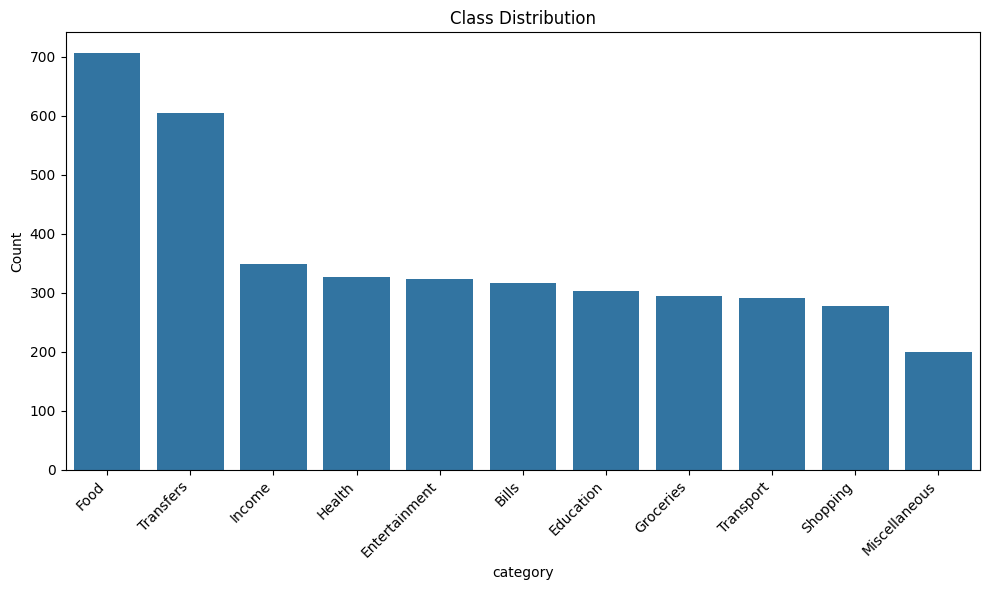

In [ ]:
# Count classes
class_counts = final_df['category'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)

# Automatically align tick labels with class names
plt.xticks(rotation=45, ha='right')  # Rotates for better visibility
plt.ylabel("Count")
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

Less imbalance in the final dataset, even tho Food is still much more weighted; however, acceptable as food would generally be the biggest expense that people make, and as such would be representative of real-world datasets. Importance is that the rest of the categories have adequate representation.

In [208]:
# Inspect generated data
final_df[final_df["category"] == "Entertainment"].sample(10)

,date,description,amount,type,category,explanation
2785,2023-11-05,DEBIT PURCHASE 04/11/23 xx-1234 NETFLIX,-15.00,Withdrawal,Entertainment,Monthly subscription payment for Netflix.
2521,2022-01-28,DEBIT PURCHASE 27/01/22 xx-1234 CONCERT TICKETS,-50.00,Withdrawal,Entertainment,Payment for concert tickets using a debit card.
2525,2022-02-23,FAST PAYMENT 23/02/22 xx-1234 STEAM,-20.00,Withdrawal,Entertainment,Payment for a game on Steam using FAST payment.
2652,2023-07-10,DEBIT PURCHASE 10/07/23 xx-0411 NINTENDO ESHOP,-40.00,Withdrawal,Entertainment,Bought a game from the Nintendo eShop.
2630,2023-12-25,DEBIT PURCHASE 24/12/23 xx-2007 HBO MAX,-14.99,Withdrawal,Entertainment,Monthly HBO Max subscription.
2608,2023-12-03,DEBIT PURCHASE 02/12/23 xx-0532 PLAYSTATION STORE,-60.00,Withdrawal,Entertainment,Purchased a new game on the PlayStation Store.
496,2023-10-20,DEBIT PURCHASE 17/10/23 xx-0411 BOOKMYSHOW SEA...,-90.00,Withdrawal,Entertainment,This is a payment for a service or event booke...
2711,2023-03-05,DEBIT PURCHASE 04/03/23 xx-8899 BAR LOUNGE,-60.00,Withdrawal,Entertainment,Payment for drinks at Bar Lounge.
2768,2023-05-12,DEBIT PURCHASE 11/05/23 xx-4523 GAMING EQUIPMENT,-120.00,Withdrawal,Entertainment,Payment for gaming equipment.
2617,2023-12-12,FAST PAYMENT 11/12/23 xx-1458 KARAOKE NIGHT,-60.00,Withdrawal,Entertainment,Paid for karaoke night.


In [209]:
def debit_or_credit(text):
    # To create more variance in the dataset; including credit purchases rather than just debit purchases. 
    if "DEBIT" in text:
        rand = random.choice([0, 1])
        if rand:
            return re.sub(r"\bDEBIT\b", "CREDIT", text)
        else:
            return text
    else: return text

In [210]:
final_df["description"] = final_df["description"].apply(debit_or_credit)

In [217]:
final_df.sample(10)

,date,description,amount,type,category,explanation
2419,2023-06-07,GIRO PAYMENT 06/06/23 xx-7749 UBER,-18.00,Withdrawal,Bills,Uber ride payment.
1452,2024-12-25,CASH REBATE CASH REBATE,1.58,Deposit,Income,"This is a cash rebate, which is a form of income."
3839,2022-03-15,DEBIT PURCHASE 15/03/22 xx-0411 RedMart,-90.20,Withdrawal,Groceries,Online grocery shopping from RedMart.
2549,2022-08-10,CREDIT PURCHASE 09/08/22 xx-1234 CONCERT TICKETS,-50.00,Withdrawal,Entertainment,Payment for concert tickets using a debit card.
1891,2024-05-31,CREDIT PURCHASE 29/05/24 xx-6482 EZ-LINK APP S,-20.00,Withdrawal,Transport,This is a payment for a transport service thro...
2724,2023-09-15,CREDIT PURCHASE 14/09/23 xx-8899 BAR LOUNGE,-60.00,Withdrawal,Entertainment,Payment for drinks at Bar Lounge.
2052,2023-08-01,GIRO PAYMENT TO NATIONAL UNIVERSITY,-1000.00,Withdrawal,Education,Payment for university tuition fees.
2107,2023-02-20,DEBIT PURCHASE xx-5678 AMAZON,-30.00,Withdrawal,Education,Purchased educational materials from Amazon.
953,2023-07-25,DEBIT PURCHASE 23/07/23 xx-6482 EZ-LINK APP S,-20.00,Withdrawal,Transport,This is a withdrawal transaction for a transpo...
3031,2023-12-25,CREDIT PURCHASE 24/12/23 xx-0411 WALGREENS,-15.00,Withdrawal,Health,Payment for health supplements at Walgreens.


In [218]:
final_df.to_csv("./data/final_dataset_cleaned.csv", index=False)